In [1]:
import os
import glob
import shutil
import numpy as np
import random
import scipy.misc

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import load_model, model_from_json, Model
from tensorflow.keras.layers import *
from tensorflow.keras import losses
from tensorflow.keras.preprocessing import image as kpi
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
def get_image_data(img_path, image_size, space='rgb'):
    if space=='rgb':
        img = kpi.load_img(img_path, target_size=image_size)
        x = kpi.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        data = x[0]
    elif space=='gray':
        img = kpi.load_img(img_path, target_size=image_size, grayscale=True)
        x = kpi.img_to_array(img)
        x /= 255.
        data = x
    elif space=='hsv':
        imc = cv2.imread(img_path)
        imc = cv2.resize(imc, (image_size[1],image_size[0]))
        hsv = cv2.cvtColor(imc, cv2.COLOR_BGR2HSV)
        data = hsv
    return data

def create_dilate_vgg16_model(with_sigmoid=False, 
                              with_centerbias=False, 
                              with_aspp_pointwise=True,
                              aspp_sizes=None, 
                              with_aspp_pooling=False):
    model_file = os.path.expanduser('~')+'/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    
    input_x = Input(shape=(480, 640, 3))
    # vgg16 conv1
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv1')(input_x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name='block1_pool', padding='same')(x)
    
    # vgg16 conv2
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name='block2_pool', padding='same')(x)
    
    # vgg16 conv3
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name='block3_pool', padding='same')(x)
    
    # vgg16 conv4
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name='block4_pool', padding='same')(x)
    
    # vgg16 dilate conv5
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv1', dilation_rate=(1, 1))(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv2', dilation_rate=(2, 2))(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv3', dilation_rate=(3, 3))(x)
    
    dilate_vgg16_model = Model(inputs=input_x, outputs=x)
    dilate_vgg16_model.load_weights(model_file)
    
    aspp_list = []
    if with_aspp_pointwise == True:
        aspp_list.append(Conv2D(512, (1,1), activation='relu', padding='same', 
                                    name='block_aspp_point_wise')(x))
    
    if aspp_sizes != None:
        for ind, aspp_size in enumerate(aspp_sizes):
            aspp_list.append(Conv2D(512, (3,3), activation='relu', padding='same', 
                                    name='block_aspp_conv{}'.format(ind), dilation_rate=(aspp_size, aspp_size))(x))
    
    if with_aspp_pooling:
        aspp_list.append(MaxPooling2D((2,2), strides=(1,1), padding='same', name='block_aspp_maxpooling')(x))
    
    
    if len(aspp_list) > 0:
        o = Concatenate()(aspp_list)
    else:
        o = dilate_vgg16_model.get_layer('block5_conv3').output
        
    o = Conv2D(512*len(aspp_list), (1,1), activation='relu')(o)
    o = Conv2D(1024, (1,1), activation='relu')(o)
    
    o = Lambda(lambda x: x/255., name='lambda_norm')(o)
    w_o = MaxPooling2D(pool_size=(4, 4))(o)
    w_o = Flatten()(w_o)
    w_o = Dense(1024)(w_o)
    o = Multiply()([o, w_o])
    o = Conv2D(1, (1,1), name='weighted_sum')(o)
    
    if with_centerbias:
        x = MyCenterBiasLayer(name='my_centerbias_layer')(x)
    
    model = Model(inputs=input_x, outputs=o)
    return model

def NSS(y_true, y_pred):
    epsilon = 1e-7
    fix_pts = tf.where(tf.equal(y_true, tf.reduce_max(y_true)))
    std = tf.sqrt(tf.reduce_mean(tf.square(y_pred-tf.reduce_mean(y_pred))))
    mean = tf.reduce_mean(y_pred)
    y_pred_norm = (y_pred - mean) / (std + epsilon)
    return tf.reduce_mean(tf.gather_nd(y_pred_norm, fix_pts))

def Multi_Loss(y_true, y_pred):
    return 10. * losses.mse(y_true, y_pred) + (1.-tf.sigmoid(NSS(y_true, y_pred)))

In [3]:
model = create_dilate_vgg16_model(with_sigmoid=False, 
                                  with_centerbias=False, 
                                  with_aspp_pointwise=True,
                                  aspp_sizes=[3,6,9], 
                                  with_aspp_pooling=False)
model.summary()
model.compile(loss=Multi_Loss, optimizer="sgd", metrics=[])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 640, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 320, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

# Test

In [4]:
datasets = ['MIT1003']

MODEL_NAME = 'vgg16_S17_dialate_ASPPv3_pooling_25_epoch_30.h5'
model = load_model(MODEL_NAME, custom_objects={"Multi_Loss": Multi_Loss})

for dataset in datasets:
    SAVE_FOLDER = 'results/'
    if not os.path.exists(SAVE_FOLDER):
        os.mkdir(SAVE_FOLDER)

In [5]:
img = '00000.jpg'
original_img = Image.open(img)
x1 = np.expand_dims(get_image_data(img, (480, 640), space="rgb"), axis=0)
res = model.predict(x1)

# Resize the image using Pillow (PIL)
sal = Image.fromarray(np.uint8(res[0, :, :, 0] * 255), mode='L').resize(original_img.size, Image.BICUBIC)

# Blend the saliency map with the original image
combined_img = Image.new('RGB', original_img.size)
combined_img.paste(original_img, (0, 0))
combined_img.paste(sal.convert('RGB'), (0, 0), sal)

# Save the final image
#combined_img.save('output_combo_image5_t1.jpg')

# Display the final image (optional)
#combined_img.show()

# Save the resized image
sal.save('output_img5.jpg')

# Display the image (optional)
#sal.show()

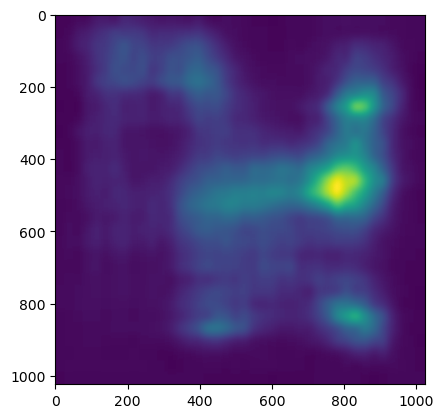

In [6]:
img = '00000.jpg'
original_img = Image.open(img)
x1 = np.expand_dims(get_image_data(img, (480, 640), space="rgb"), axis=0)
x2 = np.expand_dims(get_image_data(img, (300, 400), space="rgb"), axis=0)
res = model.predict([x1, x2])
sal = Image.fromarray(np.uint8(res[0, :, :, 0] * 255), mode='L').resize(original_img.size, Image.BICUBIC)

# Blend the saliency map with the original image
combined_img = Image.new('RGB', original_img.size)
combined_img.paste(original_img, (0, 0))
combined_img.paste(sal.convert('RGB'), (0, 0), sal)

# Save the final image
#combined_img.save('output_combo_img5_t2.jpg')

# Display the final image (optional)
#combined_img.show()
#sal = scipy.misc.imresize(res[0,:,:,0], (600, 800), interp='bicubic')
plt.imshow(sal)
plt.savefig('casnet2.jpg')
plt.show()